In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 선형 회귀 모델을 훈련시키는 두 가지 방법
### 1. 직접 계산할 수 있는 공식을 사용하여 훈련 셋에 가장 잘 맞는 모델 파라미터(훈련 셋에 대해 비용 함수를 최소화하는 모델 파라미터)를 해석적으로 구하기
### 2. 경사 하가업(GD)라는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 셋에 대해 최소화 시킴 -> 결국 1번 방법과 동일한 파라미터로 수렴

# 4.1 선형 회귀

# 4.1.1 정규방정식(Normal Equation)

### 선형 회귀 모델: y-hat = theta_0 + thata_1·x_1 + ... + theta_n·x_n

### 정규방정식: theta-hat = (X^T · X)^(-1) · X^T · y
#### theta-hat: 비용 함수를 최소화하는 theta 값
#### y: y1부터 ym까지 포함하는 타깃 벡터

In [2]:
# 비용 함수를 최소화하는 모델 파라미터 값 찾기

# 테스트를 위해 무작위로 선형처럼 보이는 데이터 생성

import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


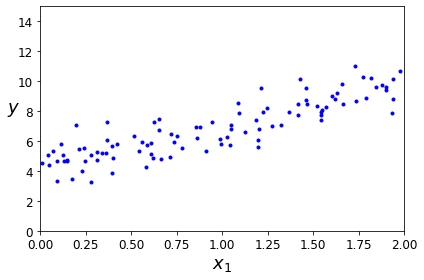

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가 (편향 theta0 = theta0 * 1이니까)
# inv(): 역행렬 계산, dot(): 행렬 곱셈
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best
# 우리가 실제 사용한 함수는 y = 4 + 3x + 가우시안_노이즈
# 정규방정식으로 계산한 값은 y = 3.92 + 2.96x -> 노이즈 때문에 원래 함수를 정확하게 재현하지는 못함

'''
가우시안 노이즈: 가우시안 분포(정규분포)를 갖는 noise
-> 쉽게 말해서 갑자기 튀는 noise도 아니고 계속 같은 신호를 보이는 noise도 아니고 그냥 일반적인 noise
'''

'\n가우시안 노이즈: 가우시안 분포(정규분포)를 갖는 noise\n-> 쉽게 말해서 갑자기 튀는 noise도 아니고 계속 같은 신호를 보이는 noise도 아니고 그냥 일반적인 noise\n'

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

In [7]:
# 위 y_predict
3.92 + 2.96 * 2

9.84

Saving figure linear_model_predictions_plot


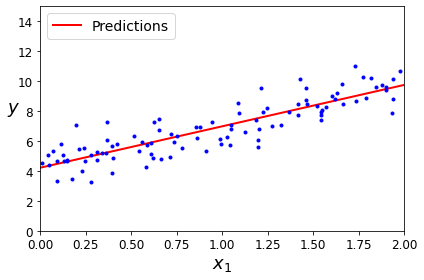

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

# 4.1.2 계산 복잡도

정규방정식은 계산 복잡도가 일반적으로 O(n^2.4)에서 O(n^3)임 -> 특성 수가 매우 많아지면 정규방정식이 매우 느려짐

다행이도 이 복잡도가 훈련 셋의 샘플 수에는 선형적으로 증가(O(m)) -> 메모리 공간이 허락된다면 큰 훈련 셋도 효율적으로 처리할 수 있음 / 이렇게 학습된 선형 회귀 모델은 예측이 매우 빠름

# 4.2 경사 하강법 (Gradient Descent)

In [11]:
# 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합한 선형 회귀 모델 훈련 방법

# 경사 하강법: 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 매우 일반적인 최적화 알고리즘
# -> 기본 아이디어: 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해 나가기
# 파라미터 벡터 theta에 대한 비용 함수의 그래디언트(비용 함수의 미분값) 계산 -> 그래디언트 감소하는 방향으로 진행 -> 그래디언트가 0이 되면 최솟값 도달!

# theta를 임의의 값으로 시작(무작위 초기화, random initialization) -> 한 번에 조금씩 비용 함수(예를 들어 MSE)가 감소되는 방향으로 진행
# -> 경사 하강법의 중요한 파라미터는 스텝의 크기(학습률, learning rate)

# 경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야함(StandarsScaler같은 것을 사용해서) -> 그렇지 않으면 훨씬 오래 걸림

# 4.2.1 배치 경사 하강법 (Batch Gradient Descent)

In [12]:
# 배치 경사 하강법: 매 경사 하강법 스텝에서 전체 훈련 셋 X에 대해 계산
# 매 스텝에서 훈련 셋 전체를 사용하기 때문에 큰 훈련 셋이서는 느림
# 하지만 경사 하강법은 특성 수에 민감하지 않기 때문에 특성이 많을 때는 정규방정식보다 경사 하강법이 빠름

# 비용 함수의 편도함수(partial derivative): 각 모델 파라미터 theta가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산하는 함수
# -> MSE를 사용한다면 편도함수는 MSE를 theta에 대해 편미분 한 것
# -> 위로 향하는 그래디언트 벡터가 구해지면 반대 방향인 아래로 가야겠지 -> theta(next steap) = theta - η * 편미분 값 -> η(학습률)

eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

# 위 정규방정식에서 찾은 값과 동일!

array([[4.21509616],
       [2.77011339]])

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [15]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


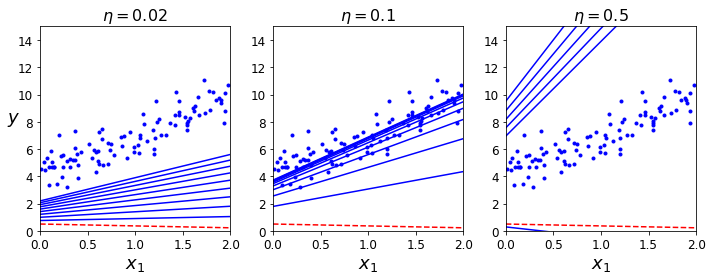

In [16]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# 세 가지 다른 학습률을 사용하여 진행한 경사 하강법의 스텝 처음 10개를 보여주는 그래프
# 점선은 시작점

# 왼쪽 그래프는 학습률이 너무 낮음 -> 최적점에 도달하겠지만 오래 걸리겠지
# 가운데는 반복 몇 번만에 이미 최적점에 수렴함 -> 학습률 아주 적당
# 오른쪽 그래프는 학습률이 너무 높음 -> 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 멀어져 발산하겠지

# 적절한 학습률을 찾으려면 그리드 탐색 사용 -> 하지만 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 함
# 반복 횟수는 어떻게 정함? -> 너무 작으면 최적점 도착 전에 멈춤, 너무 크면 모델 파라미터가 더 이상 변하지 않을 때부터 시간 낭비

# 해결책: 반복 횟수를 아주 크게 지정하고 그래디언트 벡터가 아주 작아지면,
# 즉 벡터의 노름(norm)이 어떤 값 ε(허용오차, tolerance)보다 작아지면 경사 하강법이 거의 최솟값에 도달한 것이므로 알고리즘을 중지

# 거리의 일반화가 거리함수(distance function, 혹은 metric)라면 노름은 크기의 일반화다.
# 실수의 크기(절댓값)를 ∣x∣로 표현하듯, 벡터의 크기(노름)은 일반적으로 ∥x∥ 라고 표현한다.
# 단, 저자에 따라서는 유클리드 공간의 노름을 ∣x∣로 쓰기도 한다.
# v = (2, 3)일 때, v의 norm은 (2**2 + 3**2)**(0.5)

# 수렴율: 비용 함수가 볼록 함수이고 기울기가 급격하게 바뀌지 않는 경우, 학습률을 고정한 배치 경사 하강법은 결국에는 최적의 솔루션에 수렴한 것
# 비용 함수의 모양에 따라 달라지겠지만 ε 범위 안에서 최적의 솔류션에 도달하기 위해서는 O(1/ε)의 반복이 걸릴 수 있음
# 다시 말해 허용오차 ε을 1/10으로 줄이면 알고리즘의 반복은 10배 늘어날 것임

## 노름(Norm): 벡터의 크기를 측정하는 방법(두 벡터 사이의 거리를 측정하는 방법)

### ∥x∥ = (Σ∣x_i∣^p)^(1/p)

- L1 Norm: p가 1인 Norm임. 맨허튼 노름이라고도 함. x = [1,2,3,4,5]이면 ∥x∥_1 = ∣1∣ + ∣2∣ + ∣3∣ + ∣4∣ + ∣5∣ = 15

- L2 Norm: p가 2인 Norm임. 유클리드 노름이라고도 함. x = [1,2,3,4,5]이면 ∥x∥_2 = (∣1∣^2 + ∣2∣^2 + ∣3∣^2 + ∣4∣^2 + ∣5∣^2)^0.5 = 7.4161

#### L1 Norm 상의 원 - ◇ 모양 / L2 Norm 상의 원 - ◯
#### 이러한 차이로 인해 L1 Loss는 미분이 불가능한 점이 생기고 L1 Loss가 L2 Loss에 비해 이상치(Outlier)에 둔감함(L2 Loss에는 제곱이 들어가기 때문에 이상치에 민감하겠지)

# 4.2.2 확률적 경사 하강법

In [17]:
# 배치 경사 하강법의 가장 큰 문제: 매 스텝에서 전체 훈련 셋을 사용해 그래디언트를 계산 -> 훈련 셋이 커지면 매우 느려지게 됨
# 확률적 경사 하강법은 매 스텝에서 딱 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그래디언트를 계산
# 훨씬 빠름 대신 불안정 -> 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소
# 시간이 지나면 최솟값에 매우 근접하겠지만 요동이 지속되면서 최솟값에 안착하지 못할 것 -> 알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아님

# 비용함수가 매우 불규칙할 경우 알고리즘이 지역 최솟값(local minimum)을 건너뛸 수 있도록 도와주므로
# 배치 경사 하강법보다 전역 최솟값을 찾을 가능성이 높음
# -> 무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값(global minimum)에 다다르지 못하게 한다는 점에서 좋지 않음
# 해결법: 학습률을 점진적으로 감소시키는 것 -> 시작할 때는 학습률을 크게 하고(수렴을 빠르게 하고 지역 최솟값에 빠지지 않게 함)
# -> 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 함

# -> 매 반복에서 학습률을 결정하는 함수를 '학습 스케줄(learning schedule, learning rate schedule)'이라고 함
# 학습률이 너무 빨리 줄어들면 지역 최솟값에 갇히거나 최솟값까지 가는 중간에 멈춰버릴 수도 있음
# 학습률이 너무 천천히 줄어들면 오랫동안 최솟값 주변을 맴돌거나 훈련을 너무 일찍 중지해서 지역 최솟값에 머무를 수 있음

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


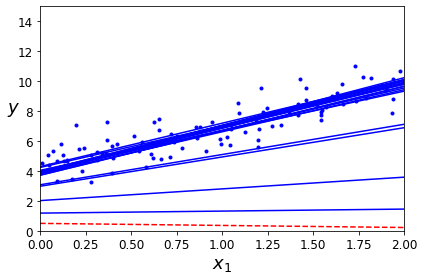

In [19]:
# 간단한 학습 스케줄을 사용한 확률적 경사 하강법 구현

n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # 무작위 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

# 훈련 스텝의 첫 20개 -> 스텝이 불규칙하게 진행하는구나
# 50번만 반복하고도 매우 좋은 값에 도달(위 배치 경사 하강법은 1000번 반복함)

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

In [21]:
# 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있음
# 알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련 셋을 섞은 후 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법을 사용할 수 있음
# 사이킷런의 SGDClassifier, SGDRegressor
# 그러나 이렇게 하면 보통 더 늦게 수렴됨

# 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용

# 학습률 0.1(eta0=0.1)로 기본 학습 스케줄(이전과는 다른)을 사용해 에포크를 50번 수행

# SGDRegressor에서 학습 스케줄을 의미하는 매개변수 learing_rate의 기본값은 invscaling: 반복 횟수 t와 eta0, power_t 두 매개변수를 사용
# eta = eta0 / (t^power_t)

# SGDClassifier에서 학습 스케줄을 의미하는 매개변수 learing_rate의 기본값은 optimal
# eta = 1 / alpha(t_0 + t)
# t_0는 alpha 매개변수와 비용함수에 따라 결정됨

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_
# 여기서도 정규방정식으로 구한 것(정답)과 매우 비슷한 값을 얻음

(array([4.24365286]), array([2.8250878]))

# 4.2.3 미니배치 경사 하강법 (Mini-batch Gradient Descent)

In [23]:
'''
각 스텝에서 전체 훈련 셋(배치 경사 하강법처럼)이나 하나의 샘플(확률적 경사 하강법처럼)을 기반으로 그래디언트를 계산하는 것이 아니라
'미니배치'라 부르는 임의의 작은 샘플에 대해 그래디언트를 계산함

장점: 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상
'''

# 미니배치를 어느 정도 크게 하면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직임
# -> 결국 미니배치 경사 하강법이 SGD보다 최솟값에 더 가까이 도달하게 되겠지
# 하지만 지역 최솟값에서 빠져나오기는 더 힘들지도 모름(지역 최솟값이 문제가 되는 경우)

theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


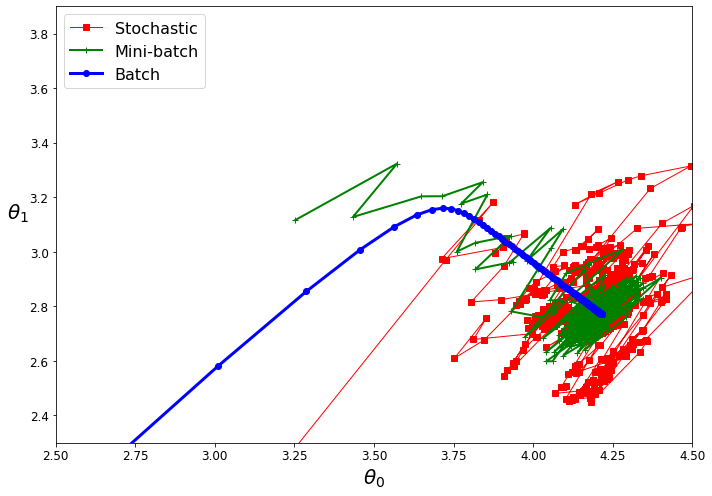

In [26]:
plt.figure(figsize=(10,7))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# 배치 경사 하강법은 최솟값에서 멈춤 / 확률적 경사 하강법과 미니배치 경사 하강법은 근처에서 맴돌고 있음
# 하지만 배치 경사 하강법은 매 스텝 오래 걸리고, 확률적 경사 하강법과 미니배치 경사 하강법도 적절한 학습 스케줄을 사용하면 최솟값에 도달할 수 있음!

In [27]:
# 선형 회귀를 사용한 알고리즘 비교 (m은 훈련 샘플 수, n은 특성 수)
# 정규방정식은 선형 회귀만을 위한 알고리즘이지만 경사 하강법 알고리즘은 여러 다른 모델도 훈련시킬 수 있음
'''
알고리즘     |      m이 클 때 | 외부 메모리 학습 지원 | n이 클 때 | 하이퍼파라미터 수  |  스케일 조정 필요  |  사이킷런

정규방정식            빠름          no              빠름           0               no            LinearRegression
배치 경사 하강법       느림          no              빠름           2               yes           n/a
확률적 경사 하강법      빠름          yes            빠름            >= 2             yes          SGDRegressor
미니배치 경사 하강법    빠름           yes            빠름            >= 2           yes            n/a
'''

'\n알고리즘     |      m이 클 때 | 외부 메모리 학습 지원 | n이 클 때 | 하이퍼파라미터 수  |  스케일 조정 필요  |  사이킷런\n\n정규방정식            빠름          no              빠름           0               no            LinearRegression\n배치 경사 하강법       느림          no              빠름           2               yes           n/a\n확률적 경사 하강법      빠름          yes            빠름            >= 2             yes          SGDRegressor\n미니배치 경사 하강법    빠름           yes            빠름            >= 2           yes            n/a\n'

# 4.3 다항 회귀 (Polynomial Regression)

In [28]:
# 가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면? -> 비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있음
# 간단한 방법으로 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것 -> 다항 회귀

# 예시) 노이즈를 포함한 2차 방정식(비선형 데이터)

import numpy as np
import numpy.random as rnd

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
# np.random.randn(m, 1): 가우시안 잡음

Saving figure quadratic_data_plot


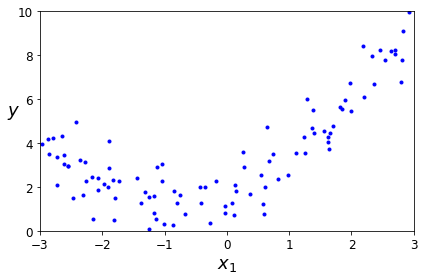

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# 특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있음
# PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문
# 예) 특성 두 개 a, b가 있고 degree=3으로 PolynomialFeatures를 적용하면 a^2, a^3, b^2, b^3뿐만 아니라 ab, (a^2)b, ab^2도 특성으로 추가
# interaction_only=False로 지정하면 거듭제곱이 포함된 항은 모두 제외됨 -> 즉 a, b, ab만 남음
# PolynomialFeatures의 객체에서 get_feature_names() 메서드를 호출하면 만들어진 특성의 차수를 쉽게 확인할 수 있음

'''
PolynomialFeatures(degree=d)는 특성이 n개인 배열을 특성이 (n+d)! / d!n!개인 배열로 변환함
(n개의 특성에서 0개 뽑는 중복 조합 + n개의 특성에서 1개 뽑는 중복 조합 + ... + n개의 특성에서 d개 뽑는 중복 조합)
'''

X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
poly_features.get_feature_names_out()

array(['x0', 'x0^2'], dtype=object)

In [32]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [33]:
# 확장된 훈련 데이터에 Linear Regression 적용해보기

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

# 원래 함수   y = 0.5x^2 + 1.0x + 2.0 + 가우시안 잡음
# 예측된 모델 y_hat = 0.56x^2 + 0.93x + 1.78

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


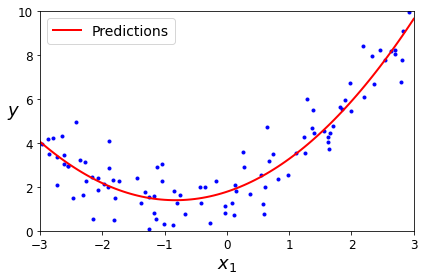

In [34]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

# 4.4 학습 곡선

Saving figure high_degree_polynomials_plot


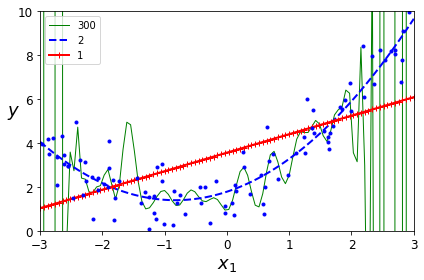

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

# 다항 회귀를 고차로(300차) 적용해 보기 -> 심각하게 과대적합(선형(1차)은 과소적합)

# 여기서는 2차 방정식으로 생성한 데이터이기 때문에 당연히 2차 다항 회귀가 제일 잘 맞음
# 그런데 일반적으로는 어떤 함수로 데이터가 생성되었는지 모름
# -> 그럼 얼마나 복잡한 모델을 사용할지 어떻게 정함? 모델이 데이터에 과대적합 또는 과소적합되었는지는 어떻게 앎?
# 2장에서 배운 교차 검증 -> 훈련 셋에서 성능이 좋지만 교차 검증 점수가 나쁘면 과대적합 / 훈련 셋에서의 성능과 교차 검증 점수 모두 나쁘면 과소적합

In [36]:
# 또 다른 방법이 학습 곡선을 살펴보는 것
# 학습 곡선: 훈련 셋과 검증 셋의 모델 성능을 훈련 셋 크기의 함수로 나타냄
# 단순히 훈련 셋에서 크기가 다른 서브 셋을 만들어 모델을 여러 번 훈련시키면 됨

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

Saving figure underfitting_learning_curves_plot


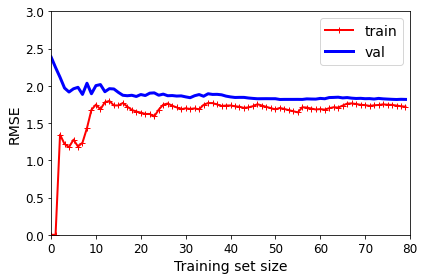

In [37]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

# 선형 회귀 모델의 학습 곡선
# 그래프가 0에서 시작 -> 훈련 셋에 하나 혹은 두 개의 샘플이 있을 땐 모델이 완벽히 작동
# 하지만 적은 수의 훈련 샘플로 훈련되었기 때문에 검증 셋(validation set)에서 오차는 매우 큼

# 샘플이 많아질수록 노이즈도 있고 비선형이기 때문에 훈련 셋의 오차가 커짐
# 하지만 학습이 되면서 검증 오차는 천천히 감소함

# 오차가 점점 비슷해짐 -> 훈련 셋, 검증 셋 모두에서 잘 안되네 -> 과소적합(이차방정식을 선형 회귀로 모델링했으니까 어쩔 수 없는 결과겠지)

Saving figure learning_curves_plot


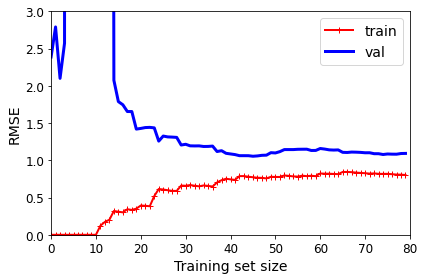

'\n위 그래프와 다른 중요한 점 두 가지\n1. training data의 오차가 선형 회귀 모델보다 훨씬 낮음\n2. 두 곡선 사이 공간이 있음 -> 훈련 셋에서의 모델 성능이 검증 셋에서보다 훨씬 괜찮음 -> 과대적합 모델의 특징\n\n과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 가까워질 때까지 훈련 데이터를 더 추가하는 것\n'

In [38]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

# 위에는 선형이었고 이번에는 10차 다항 회귀의 학습 곡선을 그려봄
'''
위 그래프와 다른 중요한 점 두 가지
1. training data의 오차가 선형 회귀 모델보다 훨씬 낮음
2. 두 곡선 사이 공간이 있음 -> 훈련 셋에서의 모델 성능이 검증 셋에서보다 훨씬 괜찮음 -> 과대적합 모델의 특징

과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 가까워질 때까지 훈련 데이터를 더 추가하는 것
'''

### 통계학과 기계 학습 분야에서 말하는 '편향-분산 트레이드오프'는 지도 학습 알고리즘이 트레이닝 셋의 범위를 넘어 지나치게 일반화 하는 것을 예방하기 위해 두 종류의 오차를 최소화 할 때 겪는 문제이다.

편향(y절편 아님!!): 잘못된 가정으로 인한 오차 -> 예를 들어 데이터가 실제로는 2차인데 선형으로 가정함 -> 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉬움

분산: 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타남 -> 자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있음

줄일 수 없는 오차: 데이터 자체에 있는 노이즈 때문에 발생

#### 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향이 줄어듦. 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아짐 -> 그래서 트레이드오프

# 4.5 규제가 있는 선형 모델

In [39]:
# 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것 -> 자유도를 줄이면 데이터에 과대적합되기 더 어려워짐
# 예) 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 줄이는 것
# 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함
# 규제는 비용함수에 추가되는 것으로, 테스트 셋에서 성능을 평가하거나 실제 샘플을 예측할 때는 포함되지 않음

# 훈련에 사용되는 비용 함수와 테스트에서 사용되는 성능 지표는 다름
# 훈련에 사용되는 비용 함수는 최적화를 위해 미분 가능해야 함
# 테스트에 사용되는 성능 지표는 최종 목표에 가능한 한 가까워야 함

# 4.5.1 릿지 회귀 (Ridge Regression)

릿지 회귀의 비용 함수

J(Θ) = MSE(Θ) + α * (1/2) * Σ(Θ_i)^2 (1 <= i <= n)

결국 우리의 목적은 J(Θ)를 줄이는 것 -> α가 커질수록 J(Θ)를 최소화하기 위해 Θ_1, Θ_2, ..., Θ_n을 더 많이 줄여줘야겠지 -> 규제!!

하이퍼파라미터 α는 모델을 얼마나 많이 규제할지 조절

α=0: 릿지 회귀가 선형 회귀와 같아짐

α가 아주 크면 모든 가중치는 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨

#### 위 비용 함수의 설명
- 편향 Θ_0는 규제되지 않음(i는 1에서 시작)
- 1/2를 곱하는 이유는 미분 결과를 간단하게 만들기 위해서임

#### 릿지 회귀는 입력 특성의 스케일에 민감 -> 수행 전 데이터의 스케일을 맞추는 것이 중요(규제가 있는 모델은 대부분 마찬가지임)


### - 규제 예시
β0 + β1x + β2x^2 + β3x^3 + β4x^4라는 식으로 예측함 -> 과대적합 -> 규제를 걸어야지 -> 차수를 낮추고 싶음

-> 삼차, 사차의 계수인 β3, β4에 규제를 걸어보기 -> 비용함수 = MSE + 5000(β3^2 + β4^2)

-> 우리의 목적은 비용함수가 작아지는 것임 -> β3, β4에 5000을 곱함으로써 β3, β4가 조금만 커져도 비용함수가 확 커짐

-> β3, β4가 작아져야겠지 -> β3, β4 규제한 것임 -> 결국 2차식이 되겠지

In [40]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Saving figure ridge_regression_plot


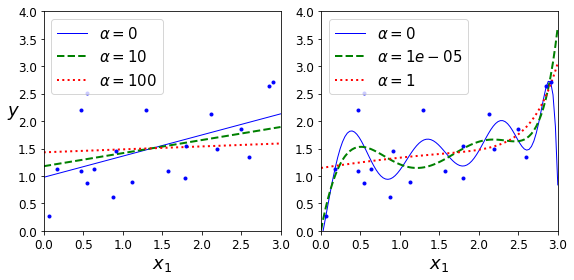

In [41]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

#### 릿지 회귀의 정규방정식

Θ_hat = (X^T·X + αA)^(-1)·X^T·y

A는 편향에 해당하는 맨 왼쪽 위의 원소가 0인 (n+1)*(n+1)의 단위행렬(편향 Θ_0는 규제에 포함되지 않기 때문)

In [42]:
# 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42) # 숄레스키 분해
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [43]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42) # 확률적 평균 경사 하강법(Stochastic Average Gradient Descent)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

In [44]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42) # 확률적 경사 하강법에서 l2 규제(릿지와 동일)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

# 4.5.2 라쏘 회귀

In [45]:
# 라쏘(Lasso, Least Absolute Shrinkage and Selection Operator) 회귀는 선형 회귀의 또 다른 규제된 버전

라쏘 회귀의 비용 함수

J(Θ) = MSE(Θ) + α * Σ∣Θ_i∣ (1 <= i <= n)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


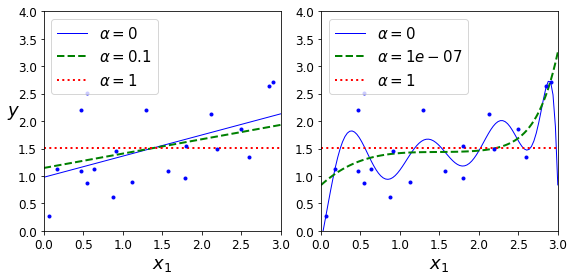

In [46]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

# 릿지 모델보다 조금 더 작은 α 값을 사용함

# 라쏘 회귀의 중요한 특징: 덜 중요한 특성의 가중치를 완전히 제거하려고 함
# 아래 α = 1e-07일 때 그래프는 2차방정식처럼 보이며 거의 선형적임 -> 차수가 높은 다항 특성의 가중치가 모두 0이 됨
# 다시 말해 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델(sparse model)을 만듦(즉, 0이 아닌 특성의 가중치가 적음)

In [47]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [49]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


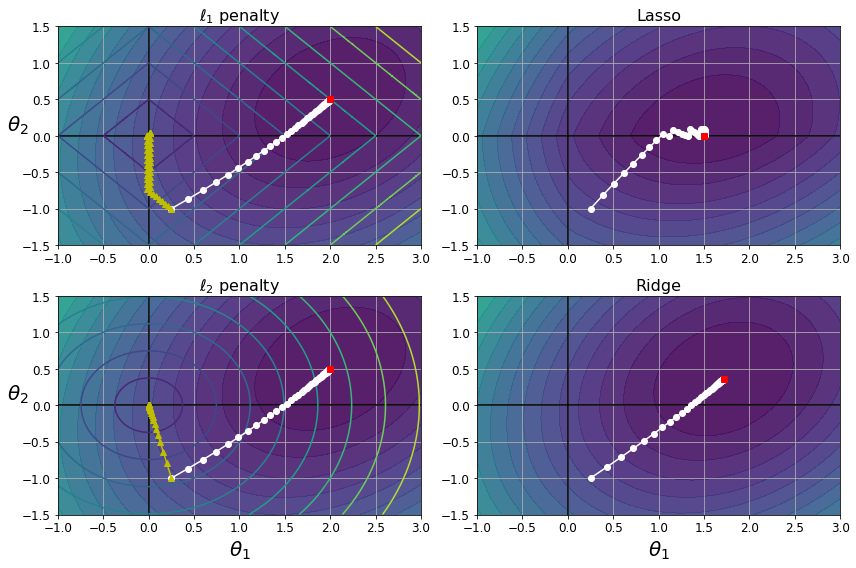

In [50]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)
    
    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

# 배경의 등고선(타원형)은 규제가 없는 MSE 비용 함수
# 다이아몬드형 - l1 penalty, 타원형 - l2 penalty
# 하얀점은 배치 경사 하강법의 경로(빨간점은 전역 최솟값)
# 노란점은 페널티에 대한 배치 경사 하강법의 경로(종점에서의 α는 ∞겠지)

# 오른쪽 그래프의 등고선은 α=0.5의 penalty가 더해진 비용 함수

# 라쏘 비용 함수에서 배치 경사 하강법의 경로가 종착지로 가는 통로에서 지그재그로 튐 -> 이는 theta2=0에서 갑자기 기울기가 변하기 때문
# 전역 최솟값에 수렴하기 위해서는 학습률을 점진적으로 줄여나가야 함

In [51]:
# 라쏘의 비용함수는 theta_i = 0(다이아몬드의 꼭짓점)에서 미분 불가능
# -> 하지만 서브그래디언트 벡터(subgradient vector)를 사용하면 경사 하강법을 적용하는 데 문제가 없음
# 모르겠음

# Lasso 클래스를 사용한 간단한 사이킷런 예제
# Lasso 대신 SGDRegressor(penalty='l1')을 사용할 수도 있음
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

# 4.5.3 엘라스틱넷 (Elastic Net)

In [52]:
# 엘라스틱넷은 릿지 회귀와 라쏘 회귀를 절충한 모델
# 규제항은 릿지와 라쏘의 규제항을 단순히 더해서 사용하고, 혼합 정도는 혼합 비율 r을 사용해 조절
# r=0이면 엘라스틱넷 = 릿지, r=1이면 엘라스틱넷 = 라쏘

# l1_ratio가 혼합 비율 r임
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [53]:
# 보통의 선형 회귀(규제 없는), 릿지, 라쏘, 엘라스틱넷을 언제 사용?
# 적어도 규제가 약간 있는 것이 대부분의 경우 좋으므로 평범한 선형 회귀는 피해야 함
# 릿지가 기본이 되지만 실제로 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 나음(불필요한 특성의 가중치를 0으로 만들어주기 때문에)
# 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있다면 보통 라쏘가 문제를 일으키므로 엘라스틱넷을 선호

# 4.5.4 조기 종료 (early stopping)

In [ ]:
# 조기 종료: 경사 하강법과 같은 반복적인 학습 알고리즘에서 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시켜 규제하는 방식

In [54]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [55]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Saving figure early_stopping_plot


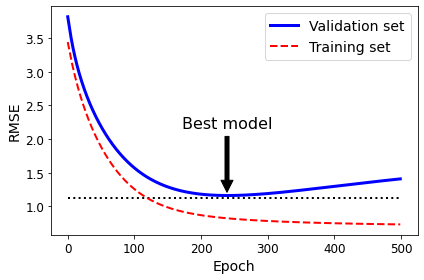

In [56]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

# 화살표 왼쪽: 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 셋에 대한 예측 에러와 검증 셋에 대한 예측 에러 감소
# 화살표 오른쪽: 과대적합으로 인해 검증 셋에 대한 예측 에러 상승

# 조기 종료: 화살표에서 멈추기 -> 매우 효과적이고 간단한 규제 테크닉임

# 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 그리 매끄럽지 않아 최솟값에 도달했는지 확인하기 어려울 수 있음
# -> 검증 에러가 일정 시간 동안 최솟값보다 클 때(모델이 더 나아지지 않는다고 확신이 들 때)
#    학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌림

In [57]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# 4.6 로지스틱 회귀

In [60]:
# 로지스틱 회귀는 분류에 사용할 수 있는 알고리즘(특정 클래스에 속할 확률을 추정하는 데 널리 사용됨)
# 추정 확률이 50%를 넘으면 그 샘플이 해당 클래스에 속함 / 50% 아래면 그 샘플이 해당 클래스에 속하지 않음 -> 이진 분류기

# 4.6.1 확률 추정

In [61]:
# 시그모이드 함수는 S자형 곡선 또는 시그모이드 곡선을 갖는 수학 함수이다.
# 시그모이드 함수의 예시로는 첫 번째 그림에 표시된 로지스틱 함수가 있으며 다음 수식으로 정의된다.
# 로지스틱 함수 σ(t) = 1 / (1+exp(-t))

Saving figure logistic_function_plot


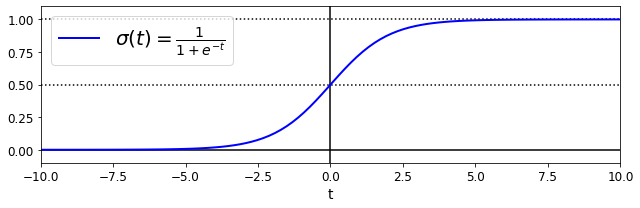

In [62]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

# 4.6.2 훈련과 비용 함수

### 하나의 훈련 샘플에 대한 비용 함수

c(Θ) = -log(p)          >>>>>  y = 1일 때

c(Θ) = -log(1 - p)     >>>>>  y = 0일 때

### 로지스틱 회귀의 비용 함수(로그 손실)

J(Θ) = (-1/m) * Σ(y_i * log(p_i) + (1 - y_i) * log(1 - p_i))

# 4.6.3 결정 경계

In [63]:
# 로지스틱 회귀를 위한 붖꽃 데이터셋: 세 개의 품종에 속하는 붓꽃 150개의 꽃잎과 꽃받침의 너비와 길이를 담고 있음

from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [64]:
print(iris.DESCR) # describtion

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [67]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(np.int64) # Iris-Virginica면 1, 아니면 0

In [68]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

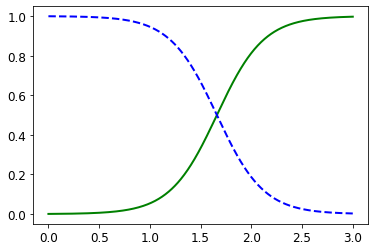

In [69]:
# 꽃잎의 너비가 0 ~ 3cm인 꽃에 대해 모델의 추정 확률을 계산

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


Saving figure logistic_regression_plot


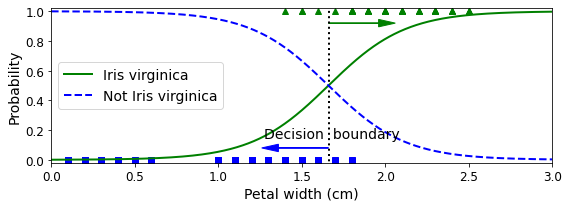

In [70]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [71]:
decision_boundary # 결정 경계: 얘를 기준으로 Iris virginica O, X 구분

array([1.66066066])

In [72]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Saving figure logistic_regression_contour_plot


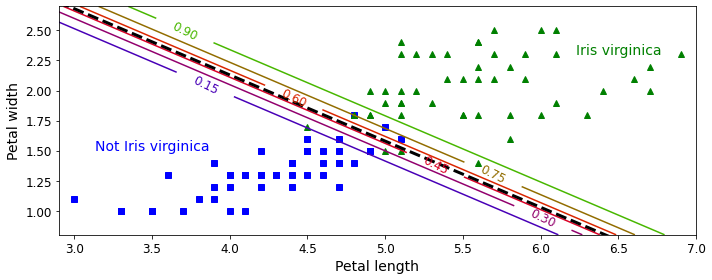

In [77]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int64)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

# 꽃잎 너비와 꽃잎 길이 두 개의 특성을 보여줌
# 점선은 결정 경계
# 나머지 직선들은 확률이 써있음 -> 오른쪽 위 초록색 직선(0.9) 위에 있는 점들은 90% 이상의 확률로 Iris virginica로 예측되겠지
# 다른 선형 모델처럼 로지스틱 회귀 모델도 l1, l2 페널티로 규제할 수 있음(사이킷런의 기본은 l2 페널티)

# 4.6.4 소프트맥스 회귀

In [ ]:
# 로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있음
# 이를 소프트맥스 회귀(Softmax Regression) 또는 다항 로지스틱 회귀(Multinomial Logistic Regression)라고 함

# Softmax 함수: k개의 값이 존재할 때 정규화(모든 데이터가 동일한 정도의 스케일로 반영되도록) -> 총 합은 1임
# -> 다시 말해 어떤 클래스에 속하는지 확률로 나타내짐(정규화된 지수 함수, normalized exponential라고 부르기도 함)

# 소프트맥스 회귀 분류기는 한 번에 하나의 클래스만 예측함 -> 다중 클래스, 다중 출력 아님!
# -> 그래서 종류가 다른 붓꽃 같이 상호 배타적인 클래스에서만 사용해야 함
# 하나의 사진에서 여러 사람의 얼굴을 인식하는 데는 사용할 수 없음

# 크로스 엔트로피 비용 함수를 최소화하는 것: 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합함
# 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용됨
# 크로스 엔트로피: sigma(p * log(q))


# 8가지 날씨(맑음, 비 등)가 있다면 8 = 2**3이므로 3비트를 사용하여 인코딩할 수 있음(000, 001, 010, 011, 100, 101, 110, 111)
# 그런데 거의 매일 맑음이라면 맑음을 하나의 비트(0)로 인코딩하고 다른 일곱 개의 선택사항을 4비트(1로 시작하는)로 표현하는 것이 효율적
# (0, 1000, 1001, 1010, 1011, 1101, 1110, 1111)

# 만약 맑은 날의 비율이 80%라면 위 경우는 평균 3비트, 아래 경우는 평균 1.6비트

In [78]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


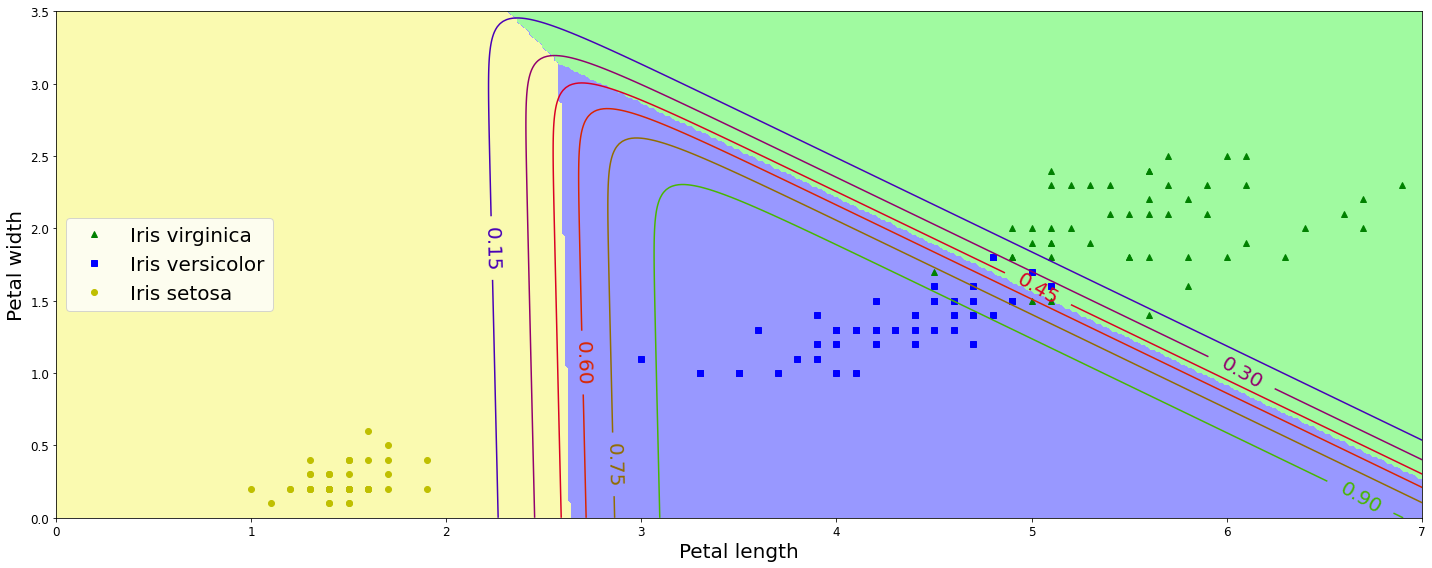

In [84]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(20, 8))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=20)
plt.xlabel("Petal length", fontsize=20)
plt.ylabel("Petal width", fontsize=20)
plt.legend(loc="center left", fontsize=20)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

# 모든 결정 경계가 만나는 지점: 모든 클래스가 동일하게 33%
# 추정 확률 50% 이하인 클래스를 예측할 수도 있음!

In [80]:
softmax_reg.predict([[5, 2]]) # 꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃 -> class 2(Iris-Virginica)라고 예측

array([2])

In [81]:
softmax_reg.predict_proba([[5, 2]])
# 꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃 -> class 1: 매우 작은 확률, class 2: 5.7%, class 3: 94.2%

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])